# Máquinas de vectores de soporte

### Autor: Luis Ardévol Mesa

## Ejercicio 2

Antes de comenzar, verificamos que el entorno de ejecución esté configurado con las librerías necesarias (no ejecutar en cesga).

In [1]:
import subprocess
import sys
import pkg_resources

def check_and_install_packages():
    required_packages = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'scikit-learn': 'scikit-learn',
        'matplotlib': 'matplotlib'
    }
    
    missing_packages = []
    
    # Verificar paquetes instalados
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    
    for package, pip_name in required_packages.items():
        if package not in installed_packages:
            missing_packages.append(pip_name)
    
    # Instalar paquetes faltantes
    if missing_packages:
        print("Instalando paquetes necesarios...")
        for package in missing_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Instalación completada.")
    else:
        print("Todos los paquetes necesarios ya están instalados.")

check_and_install_packages()

Todos los paquetes necesarios ya están instalados.


Ahora importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
#matplotlib.style.use('seaborn-v0_8-ticks')

**Definición de variables globales**

In [2]:
DATASET_NAME = 'bloodTransfusion.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

**Lectura del fichero de datos**

In [3]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X0", "X1", "X2", "X3", "Y"])
dataset

,X0,X1,X2,X3,Y
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. En este caso, Y no interesa tanto ya que es una variable binaria. Veremos su distribución de clases más adelante. 

In [4]:
print(f"Valores faltantes: \n{dataset.isnull().sum()}\n")
print("Estadísticas de los predictores:")
dataset.loc[:, "X0":"X3"].describe()

Valores faltantes: 
X0    0
X1    0
X2    0
X3    0
Y     0
dtype: int64

Estadísticas de los predictores:


,X0,X1,X2,X3
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


El fichero contiene 5 variables y 748 observaciones distintas. Las variables predictoras son `X0`, `X1`, `X2`, `X3`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

**Visualización de los datos**

Distribución de clases en la variable de salida: 
0    570
1    178
Name: Y, dtype: int64


/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


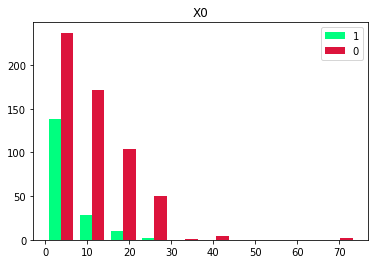

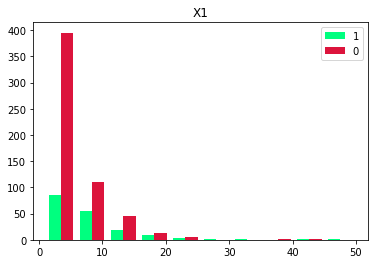

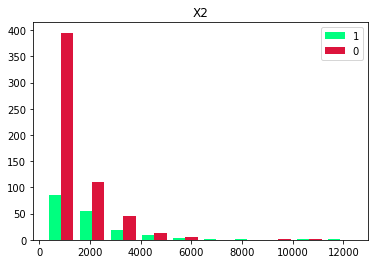

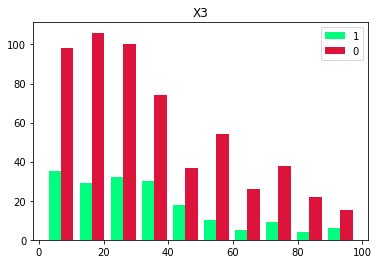

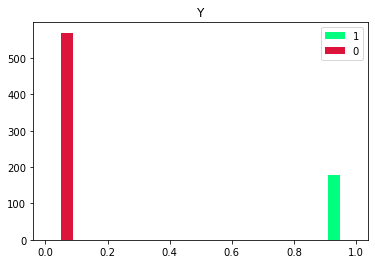

In [5]:
def distClases(data, etiquetas = ['1', '0'], colores=['springgreen', 'crimson']):
    print(f"Distribución de clases en la variable de salida: \n{data['Y'].value_counts()}")
    
    for column in data:  # Visualizamos la distribución de variables por clases
        plt.title(column)
        clases = [data[data['Y'] == eval(i)][column] for i in etiquetas]
        plt.hist(clases, label=etiquetas, color=colores)
        plt.legend(loc='upper right')
        plt.show()


distClases(dataset)

También podemos visualizar los datos y sus clases por pares de atributos:

Correlación numérica entre las variables: 
          X0        X1        X2        X3         Y
X0  1.000000 -0.182745 -0.182745  0.160618 -0.279869
X1 -0.182745  1.000000  1.000000  0.634940  0.218633
X2 -0.182745  1.000000  1.000000  0.634940  0.218633
X3  0.160618  0.634940  0.634940  1.000000 -0.035854
Y  -0.279869  0.218633  0.218633 -0.035854  1.000000


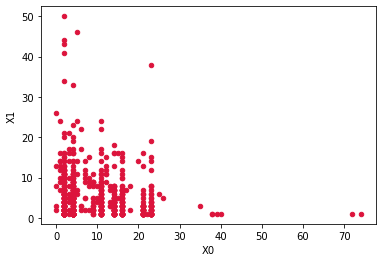

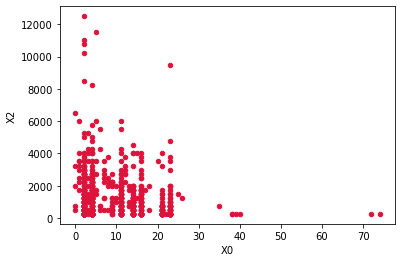

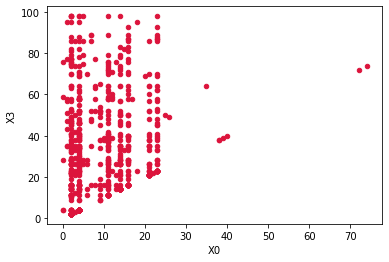

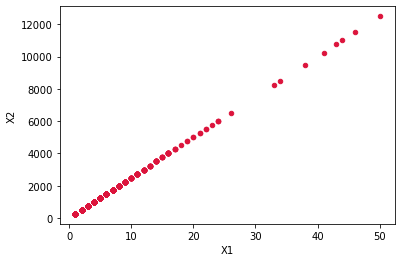

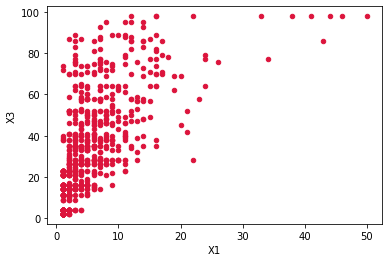

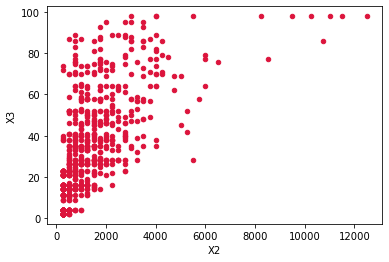

In [6]:
def distPares(data):
    print(f"Correlación numérica entre las variables: \n{data.corr()}") # correlación entre las variables

    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    # Ahora representamos atributos por pares (mostrando también la clase)
    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    for i, columna_i in enumerate(column_names):
        for j, columna_j in enumerate(column_names):
            if i < j:
                fig, ax = plt.subplots()
                data.plot.scatter(columna_i, columna_j, c='crimson', ax=ax)

distPares(dataset)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [7]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["Y"])
dataset_test

,X0,X1,X2,X3,Y
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
...,...,...,...,...,...
315,4,2,500,29,0
473,14,3,750,83,0
661,16,2,500,16,0
362,4,3,750,71,0


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera. `SimpleImputer` convierte nuestros valores a un array NumPy, por lo que sería bueno que se vuelven a convertir a formato dataframe.

In [8]:
def valoresFaltantes(trainData, testData, mis_val=np.nan, fill_val='mean'):
    imp = SimpleImputer(missing_values=mis_val, fill_value=fill_val) # definimos el mapa
    imp = imp.fit(trainData)  # La media la calculamos SÓLO a partir del conjunto de train 

    # Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
    dataset_train_prep = imp.transform(trainData) # aqui modificamos los datos de train
    dataset_test_prep = imp.transform(testData) # aqui modificamos los datos de test (se usa la media de entrenamiento)

    dataset_train = pd.DataFrame(dataset_train_prep, 
                                 columns=trainData.columns, 
                                 index=trainData.index)
    dataset_test = pd.DataFrame(dataset_test_prep, 
                                columns=testData.columns, 
                                index=testData.index)

    return dataset_train, dataset_test

dataset_train, dataset_test = valoresFaltantes(dataset_train, dataset_test)
dataset_test

,X0,X1,X2,X3,Y
309,16.0,3.0,750.0,19.0,0.0
711,23.0,6.0,1500.0,45.0,0.0
343,11.0,1.0,250.0,11.0,0.0
462,21.0,1.0,250.0,21.0,1.0
646,14.0,2.0,500.0,14.0,0.0
...,...,...,...,...,...
315,4.0,2.0,500.0,29.0,0.0
473,14.0,3.0,750.0,83.0,0.0
661,16.0,2.0,500.0,16.0,0.0
362,4.0,3.0,750.0,71.0,0.0


### Separación de variables predictoras y dependientes y estandarización de los datos

Es recomendable hacer siempre la estandarización de los datos. Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test. En los problemas de clasificación, **NO** estandarizaremos la variable dependiente, pero esto sí es necesario en problemas de regresión.

Definimos una función que, dada los datos de entrenamiento y *test*, separa las varibles predictoras y dependientes (especificadas en los parámetros `preds` y `dep`), y estandariza las variables predictoras o las predictoras y las dependientes (el parámetro `escalar = [True, True]` controla el escalado de las variables: el primer elemento indica si se estandarizan las variables predictoras o no (en este último caso da error, ya que es necesario), y el segundo elemento hace lo mismo con las variables dependientes). 

In [9]:
def splitScale(trainData, testData, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar = [True, True]):

    dataset_train_X = trainData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_train_Y = trainData.loc[:, dep].astype(float)

    dataset_test_X = testData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_test_Y = testData.loc[:, dep].astype(float)

    if escalar[0]:
        scalerX = StandardScaler() # creamos el scaler
        scalerX.fit(dataset_train_X) # ajustamos a los datos de TRAIN

        dataset_train_X_scaled = scalerX.transform(dataset_train_X)
        dataset_test_X_scaled = scalerX.transform(dataset_test_X)

        print("Valores con los que se ha estandarizado:\n")
        
        statsPreds = pd.DataFrame([scalerX.mean_, scalerX.scale_], 
                                  index = ['Mean', 'std'], 
                                  columns = preds)
        print(f"{statsPreds}\n")

        if escalar[1]:
            
            dataset_train_Y = dataset_train_Y.to_frame()
            dataset_test_Y = dataset_test_Y.to_frame()
            
            scalerY = StandardScaler()
            scalerY.fit(dataset_train_Y) # ajustamos a los datos de TRAIN

            dataset_train_Y_scaled = scalerY.transform(dataset_train_Y)
            dataset_test_Y_scaled = scalerY.transform(dataset_test_Y)

            statsDep = pd.DataFrame([scalerY.mean_, scalerY.scale_], 
                                    index = ['Mean', 'std'], 
                                    columns = [dep])
            print(statsDep)

            return dataset_train_X_scaled, dataset_train_Y_scaled, dataset_test_X_scaled, dataset_test_Y_scaled, [scalerX, scalerY]
        
        return dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX
    
    else: 
        raise ValueError("Es necesario escalar los predictores")

In [10]:
dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scaler = splitScale(dataset_train, dataset_test, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar=[True, False])

Valores con los que se ha estandarizado:

            X0        X1           X2         X3
Mean  9.508361  5.637124  1409.280936  34.879599
std   7.893041  5.893176  1473.294031  24.729957



### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

`GridSearch` admite una gran variedad de modelos, por lo que definir una función que lo aplique resultará de utilidad. Pasando el modelo a usar el *grid* de hiperparámetros, obtenemos los resultados de los modelos explorados. Además, como lo usaremos con frecuencia, añadimos una columna a los resultados calculando el error medio. 

In [11]:
def crossVal(trainDataX, trainDataY, modelo, hiperparametros, cv = 5, scoring = 'accuracy'):
    modelCV = GridSearchCV(modelo, 
                           param_grid = hiperparametros, # grid de hiperparametros
                           cv = cv, # conjuntos de validacion cruzada (folds)
                           scoring = scoring, # metrica de evaluacion 
                           return_train_score = True, 
                           verbose = 3)
    
    np.random.seed(SEED_VALUE) 
    modelCV.fit(trainDataX, trainDataY)
    resultados = pd.DataFrame(modelCV.cv_results_)
    
    if scoring == 'accuracy': 
        resultados['mean_test_error'] = 1 - resultados.loc[:, 'mean_test_score']

    return modelCV, resultados

**Exploración de grano grueso**

En esta práctica, exploraremos distintos tipos de *kernel* (lineal, polinómico y radial), así como los valores del parámetro de regularización `C` (para todos los *kernel*, `gamma` para el *kernel* radial y el grado del polinomio para el *kernel* polinómico). Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo. 

Debido a la cantidad de modelos a explorar, lo haremos para cada kernel por separado y guardaremos los resultados del entrenamiento.

**Kernel lineal**

Para el *kernel* lineal buscaremos con valores de `C' desde $10^{-4}$ hasta $10^8$, dando saltos de dos en la potencia. 

In [39]:
valoresC_gg_lineal = [10**i for i in range(-4, 9, 2)] # -4, -2, 0, 2, 4, 6, 8 

hyperparameters_gg_lineal = {'kernel': ['linear'], 'C': valoresC_gg_lineal}

svm_gg_lineal = SVC(random_state=SEED_VALUE)

modeloCV_gg_lineal, cv_results_gg_lineal = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                                    svm_gg_lineal, hyperparameters_gg_lineal)
with open('cv_results_gg_lineal.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_lineal, f)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ........................C=0.0001, kernel=linear; total time=   0.0s
[CV 2/5] END ........................C=0.0001, kernel=linear; total time=   0.0s
[CV 3/5] END ........................C=0.0001, kernel=linear; total time=   0.0s
[CV 4/5] END ........................C=0.0001, kernel=linear; total time=   0.0s
[CV 5/5] END ........................C=0.0001, kernel=linear; total time=   0.0s
[CV 1/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 2/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 3/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 4/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 5/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 1/5] END .............................C=1, kernel=linear; total time=   0.0s
[CV 2/5] END .............................C=1, ke

**Kernel polinómico**

Para el *kernel* polinómico fijamos $\gamma = 1$. Buscaremos valores del grado del polinomio, desde 2 hasta 5. Debido al tiempo de cómputo, haremos la exploración de cada grado del polinomio por separado. El rango por donde buscaremos los valores de `C` irá variando para cada grado del polinomio.

**Polinomio de grado 2**

Buscamos valores de `C` desde $10^{-4}$ hasta $10^8$, dando saltos de tres en la potencia.

In [15]:
valoresC_gg_poly2 = [10**i for i in range(-4, 9, 3)] # -4, -1, 2, 5, 8

hyperparameters_gg_poly2 = {'kernel': ['poly'], 'C': valoresC_gg_poly2, 'degree': [2], 'gamma': [1]}

svm_gg_poly2 = SVC(random_state=SEED_VALUE)

modeloCV_gg_poly2, cv_results_gg_poly2 = crossVal(dataset_train_X_scaled, 
                                                 np.ravel(dataset_train_Y.astype(int)),
                                                 svm_gg_poly2, 
                                                 hyperparameters_gg_poly2)

with open('cv_results_gg_poly2.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_poly2, f)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END .......C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END .......C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END .......C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END .......C=0.0001, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ..........C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ..........C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ..........C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ..........C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END ..........C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ..........C=100, degree=2, gamma=1, kernel=poly; total time=  27.2s
[CV 2/5] END ..........C=100, degree=2, gamma=1, 

**Polinomio de grado 3**

Buscamos valores de `C` desde $10^{-3}$ hasta $10^5$, dando saltos de dos en la potencia.

In [12]:
valoresC_gg_poly3 = [10**i for i in range(-3, 6, 2)] # -3, -1, 1, 3, 5

hyperparameters_gg_poly3 = {'kernel': ['poly'], 'C': valoresC_gg_poly3, 'degree': [3], 'gamma': [1]}

svm_gg_poly3 = SVC(random_state=SEED_VALUE)
modeloCV_gg_poly3, cv_results_gg_poly3 = crossVal(dataset_train_X_scaled, 
                                                 np.ravel(dataset_train_Y.astype(int)),
                                                 svm_gg_poly3, 
                                                 hyperparameters_gg_poly3)

with open('cv_results_gg_poly3.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_poly3, f)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ........C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ........C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ........C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END ........C=0.001, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ..........C=0.1, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END ..........C=0.1, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END ..........C=0.1, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END ..........C=0.1, degree=3, gamma=1, kernel=poly; total time=   0.1s
[CV 5/5] END ..........C=0.1, degree=3, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   3.1s
[CV 2/5] END ...........C=10, degree=3, gamma=1, 

**Polinomio de grado 4**

Buscamos valores de `C` [$10^{-4}$, $10^{-2}$, $10^0$ y $10^1$]. 

In [13]:
valoresC_gg_poly4 = [10**i for i in range(-4, 2, 2)] + [10] # -4, -2, 0, 1

hyperparameters_gg_poly4 = {'kernel': ['poly'], 'C': valoresC_gg_poly4, 'degree': [4], 'gamma': [1]}

svm_gg_poly4 = SVC(random_state=SEED_VALUE)
modeloCV_gg_poly4, cv_results_gg_poly4 = crossVal(dataset_train_X_scaled, 
                                                 np.ravel(dataset_train_Y.astype(int)),
                                                 svm_gg_poly4, 
                                                 hyperparameters_gg_poly4)

with open('cv_results_gg_poly4.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_poly4, f)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 2/5] END .......C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END .......C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 4/5] END .......C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 5/5] END .......C=0.0001, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END .........C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV 2/5] END .........C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV 3/5] END .........C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV 4/5] END .........C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.1s
[CV 5/5] END .........C=0.01, degree=4, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ............C=1, degree=4, gamma=1, kernel=poly; total time=  29.4s
[CV 2/5] END ............C=1, degree=4, gamma=1, 

**Polinomio de grado 5**

Buscamos valores de `C` [$10^{-4}$, $10^{-1}$ y $10^1$.

In [14]:
valoresC_gg_poly5 = [10**(-4), 10**(-1), 1] # -4, -1, 1

hyperparameters_gg_poly5 = {'kernel': ['poly'], 'C': valoresC_gg_poly5, 'degree': [5], 'gamma': [1]}

svm_gg_poly5 = SVC(random_state=SEED_VALUE)
modeloCV_gg_poly5, cv_results_gg_poly5 = crossVal(dataset_train_X_scaled, 
                                                 np.ravel(dataset_train_Y.astype(int)),
                                                 svm_gg_poly5, 
                                                 hyperparameters_gg_poly5)

with open('cv_results_gg_poly5.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_poly5, f)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .......C=0.0001, degree=5, gamma=1, kernel=poly; total time=   0.3s
[CV 2/5] END .......C=0.0001, degree=5, gamma=1, kernel=poly; total time=   0.0s
[CV 3/5] END .......C=0.0001, degree=5, gamma=1, kernel=poly; total time=   0.1s
[CV 4/5] END .......C=0.0001, degree=5, gamma=1, kernel=poly; total time=   0.1s
[CV 5/5] END .......C=0.0001, degree=5, gamma=1, kernel=poly; total time=   0.0s
[CV 1/5] END ..........C=0.1, degree=5, gamma=1, kernel=poly; total time=  19.8s
[CV 2/5] END ..........C=0.1, degree=5, gamma=1, kernel=poly; total time=   6.5s
[CV 3/5] END ..........C=0.1, degree=5, gamma=1, kernel=poly; total time=  41.2s
[CV 4/5] END ..........C=0.1, degree=5, gamma=1, kernel=poly; total time= 1.1min
[CV 5/5] END ..........C=0.1, degree=5, gamma=1, kernel=poly; total time=   0.7s
[CV 1/5] END ............C=1, degree=5, gamma=1, kernel=poly; total time=  28.4s
[CV 2/5] END ............C=1, degree=5, gamma=1, 

Abrimos los archivos guardados para cada grado del polinimio y los concatenamos en un solo dataframe para visualizar los resultados.

In [2]:
with open('resultados/cv_results_gg_poly2.pkl', 'rb') as f:
    cv_results_gg_poly2 = pickle.load(f)

with open('resultados/cv_results_gg_poly3.pkl', 'rb') as f:
    cv_results_gg_poly3 = pickle.load(f)

with open('resultados/cv_results_gg_poly4.pkl', 'rb') as f:
    cv_results_gg_poly4 = pickle.load(f)

with open('resultados/cv_results_gg_poly5.pkl', 'rb') as f:
    cv_results_gg_poly5 = pickle.load(f)
    
cv_results_gg_poly = pd.concat([cv_results_gg_poly2, cv_results_gg_poly3, 
                                cv_results_gg_poly4, cv_results_gg_poly5], ignore_index=True)

cv_results_gg_poly = cv_results_gg_poly.sort_values(['param_degree', 'param_C'])

**Kernel radial**

Buscamos valores de `C` desde $10^{-4}$ hasta $10^5$, dando saltos de tres en la potencia, y valores de `gamma` en el mismo rango y con los mismos saltos.

In [20]:
valoresC_gg_rbf = [10**i for i in range(-4, 6, 3)] # -4, -1, 2, 5

gamma_gg_rbf = [10**i for i in range(-4, 6, 3)] # -4, -1, 2, 5

hyperparameters_gg_rbf = [{'kernel': ['rbf'], 'C': valoresC_gg_rbf, 'gamma': gamma_gg_rbf}]


svm_gg_rbf = SVC(random_state=SEED_VALUE)

modeloCV_gg_rbf, cv_results_gg_rbf = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                                svm_gg_rbf, hyperparameters_gg_rbf)

with open('cv_results_gg_rbf.pkl', 'wb') as f:
    pickle.dump(cv_results_gg_rbf, f)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .............C=0.0001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 2/5] END .............C=0.0001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 3/5] END .............C=0.0001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 4/5] END .............C=0.0001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 5/5] END .............C=0.0001, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV 1/5] END ................C=0.0001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ................C=0.0001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END ................C=0.0001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END ................C=0.0001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END ................C=0.0001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ................C=0.0001, gamma=100, kernel=rbf; total time=   0.0s
[CV 2/5] END ................C=0.0001, gamma=100

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid=[{'C': [0.0001, 0.1, 100, 100000],
                          'gamma': [0.0001, 0.1, 100, 100000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy', verbose=3)

**Gráfica de entrenamiento (primera aproximación)**

Aqui deberiamos tener una grafica más o menos convexa para ver que ahi esta el minimo. Hacemos una función que grafique el error frente al parámetro de regularización `C` para cada kernel. Particularizamos para que mostrar, en el caso del *kernel* polinómico, todos los grados del polinomio en el mismo gráfico y, para el *kernel* radial, los valores de `gamma` en el mismo gráfico.

In [5]:
def errorVal(resultados, fig, kernel_type='linear', label='SVM', color='crimson', 
            classification=True, ejex='C'):

    if classification:
        resultados['mean_test_error'] = 1 - resultados['mean_test_score']
    else:
        resultados['mean_test_error'] = resultados['mean_test_score']
    
    results = pd.DataFrame({'param_C': resultados['param_C'], 
                            'mean_test_error': resultados['mean_test_error'], 
                            'std_test_score': resultados['std_test_score'], 
                            'rank_test_score': resultados['rank_test_score']})
    
    ax = fig.axes[0]
    colores = ['crimson', 'royalblue', 'orange', 'navy', 'indigo'] if isinstance(color, str) else color
    
    if kernel_type == 'poly':
        results['grado'] = resultados['param_degree']

        if ejex == 'C':
            x_param = 'param_C'
            group_param = 'grado'
            label_prefix = 'grado'
            xlabel = "C"
            use_log = True
        else:  
            x_param = 'grado'
            group_param = 'param_C'
            label_prefix = 'C'
            xlabel = "Grado del polinomio"
            use_log = False

        param_values = sorted(results[group_param].unique())
        for idx, param_val in enumerate(param_values):
            datos = results[results[group_param] == param_val]
            ax.errorbar(datos[x_param], datos['mean_test_error'], yerr=datos['std_test_score'], 
                        label=f"{label_prefix}={param_val} ({label})", color=colores[idx % len(colores)], 
                        capsize=3)

        ax.set_xlabel(xlabel)
        if use_log:
            ax.set_xscale('log')
            
    elif kernel_type == 'rbf':
        results['gamma'] = resultados['param_gamma']
        gamma_values = sorted(results['gamma'].unique())
        
        for idx, gamma_val in enumerate(gamma_values):
            datos = results[results['gamma'] == gamma_val]
            ax.errorbar(datos['param_C'], datos['mean_test_error'], yerr=datos['std_test_score'], 
                        label=f"gamma={gamma_val} ({label})", color=colores[idx % len(colores)], 
                        capsize=3)
            
        ax.set_xlabel("C")
        ax.set_xscale('log')
        
    else:  # linear
        ax.errorbar(results['param_C'], results['mean_test_error'], yerr=results['std_test_score'], 
                    label=label, color=colores[0], capsize=3)
        
        ax.set_xlabel("C")
        ax.set_xscale('log')
    
    ax.set_ylabel("Error de validación cruzada")
    ax.set_title(f'Kernel {kernel_type}')
    ax.legend()
    ax.grid(True, alpha=0.5)
    
    return ax

**Gráfica de grano grueso para el *kernel* lineal**

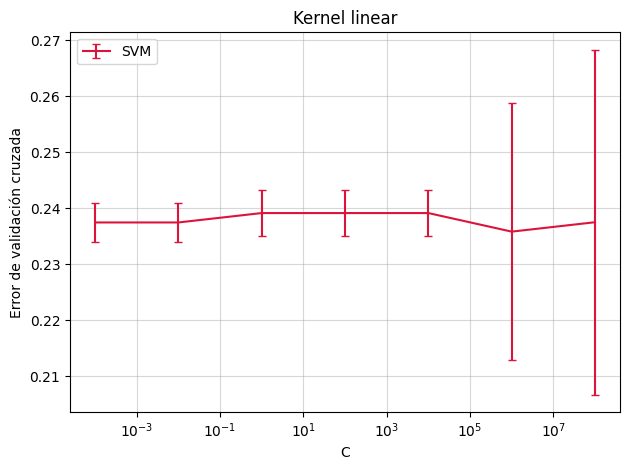

In [15]:
with open('resultados/cv_results_gg_lineal.pkl', 'rb') as f:
    cv_results_gg_lineal = pickle.load(f)

fig_gg, axes_gg = plt.subplots(1,1)

errorVal(cv_results_gg_lineal[cv_results_gg_lineal['param_kernel'] == 'linear'], fig_gg, kernel_type='linear')

fig_gg.savefig('lineal_gg.pdf')

plt.tight_layout()
plt.show()

En vista de estos resultados, buscaremos en el entorno de $C = 10^6$. Concretamente, buscaremos valores de `C` en el rango $[10^4, 10^7]$.

**Gráfica de grano grueso para el *kernel* polinómico**

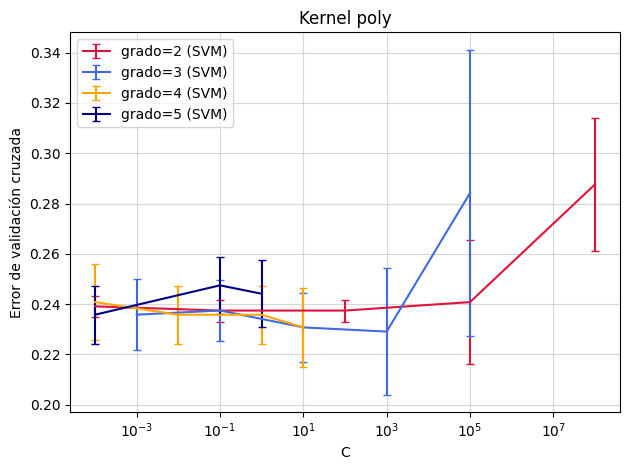

In [16]:
fig_gg_poly, axes_gg_poly = plt.subplots(1,1)

errorVal(cv_results_gg_poly[cv_results_gg_poly['param_kernel'] == 'poly'], fig_gg_poly, kernel_type='poly', ejex='C')

fig_gg_poly.savefig('poly_gg.pdf')

plt.tight_layout()
plt.show()

En vista de los resultados, fijaremos el grado del polinomio en 3 y buscaremos valores de `C` en el rango $[10^1, 10^4]$.

**Gráfica de grano grueso para el *kernel* radial**

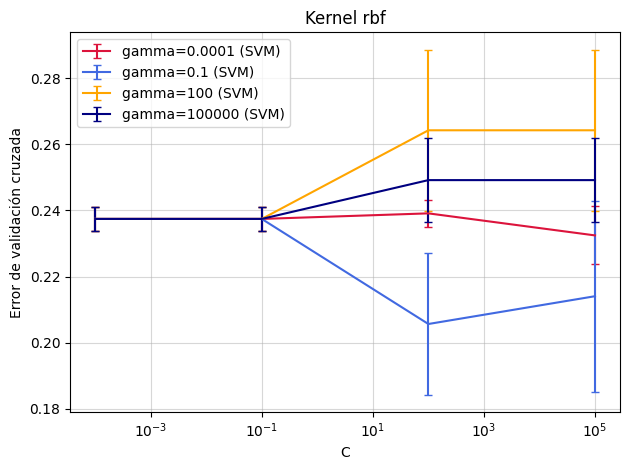

In [17]:
with open('resultados/cv_results_gg_rbf.pkl', 'rb') as f:
    cv_results_gg_rbf = pickle.load(f)

fig_gg_rbf, axes_gg_rbf = plt.subplots(1,1)

errorVal(cv_results_gg_rbf[cv_results_gg_rbf['param_kernel'] == 'rbf'], fig_gg_rbf, kernel_type='rbf')

fig_gg_rbf.savefig('rbf_gg.pdf')

plt.tight_layout()
plt.show()

En vista de los resultados, buscaremos valores de `C` en el rango $[10^0, 10^4]$ y valores de `gamma` en el rango $[10^{-2}, 10^0]$.

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo todos los valores del intervalo. Así encontraremos el modelo con el menor error de validación cruzada para este problema.

***Kernel* lineal**

Concretamente, para el *kernel* lineal buscaremos valores de `C` en el rango $[10^4, 10^7]$.

In [41]:
valoresC_gf_lineal = [10**i for i in range(4, 8, 1)] 

hyperparameters_gf_lineal = {'kernel': ['linear'], 'C': valoresC_gf_lineal}

svm_gf_lineal = SVC(random_state=SEED_VALUE)

modeloCV_gf_lineal, cv_results_gf_lineal = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                                    svm_gf_lineal, hyperparameters_gf_lineal)
with open('cv_results_gf_lineal.pkl', 'wb') as f:
    pickle.dump(cv_results_gf_lineal, f)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .........................C=10000, kernel=linear; total time=  22.6s
[CV 2/5] END .........................C=10000, kernel=linear; total time=  30.6s
[CV 3/5] END .........................C=10000, kernel=linear; total time=  31.0s
[CV 4/5] END .........................C=10000, kernel=linear; total time=  15.9s
[CV 5/5] END .........................C=10000, kernel=linear; total time=  23.1s
[CV 1/5] END ........................C=100000, kernel=linear; total time=  39.6s
[CV 2/5] END ........................C=100000, kernel=linear; total time= 1.4min
[CV 3/5] END ........................C=100000, kernel=linear; total time= 1.0min
[CV 4/5] END ........................C=100000, kernel=linear; total time=  54.5s
[CV 5/5] END ........................C=100000, kernel=linear; total time=  35.7s
[CV 1/5] END .......................C=1000000, kernel=linear; total time= 1.8min
[CV 2/5] END .......................C=1000000, ke

***Kernel* polinómico**

Concretamente, para el *kernel* polinómico fijaremos el grado del polinomio en 3 y buscaremos valores de `C` en el rango $[10^1, 10^4]$.

In [25]:
valoresC_gf_poly = [10**i for i in range(1, 5, 1)] # 1, 2, 3, 4

hyperparameters_gf_poly = {'kernel': ['poly'], 'C': valoresC_gf_poly, 'degree': [3], 'gamma': [1]}

svm_gf_poly = SVC(random_state=SEED_VALUE)
modeloCV_gf_poly, cv_results_gf_poly = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                                svm_gf_poly, hyperparameters_gf_poly)

with open('cv_results_gf_poly.pkl', 'wb') as f:
    pickle.dump(cv_results_gf_poly, f)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   3.1s
[CV 2/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   2.9s
[CV 3/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   5.3s
[CV 4/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   3.2s
[CV 5/5] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   1.0s
[CV 1/5] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  23.2s
[CV 2/5] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  39.6s
[CV 3/5] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  23.3s
[CV 4/5] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  32.9s
[CV 5/5] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  17.0s
[CV 1/5] END .........C=1000, degree=3, gamma=1, kernel=poly; total time= 2.3min
[CV 2/5] END .........C=1000, degree=3, gamma=1, 

***Kernel* radial**

Concretamente, para el *kernel* radial buscaremos valores de `C` en el rango $[10^0, 10^4]$ y valores de `gamma` en el rango $[10^{-2}, 10^0]$.

In [26]:
valoresC_gf_rbf = [10**i for i in range(0, 5, 1)] # 0, 1, 2, 3, 4

gamma_gf_rbf = [10**i for i in range(-2, 1, 1)] # 0.01, 0.1, 1

hyperparameters_gf_rbf = {'kernel': ['rbf'], 'C': valoresC_gf_rbf, 'gamma': gamma_gf_rbf}


svm_gf_rbf = SVC(random_state=SEED_VALUE)

modeloCV_gf_rbf, cv_results_gf_rbf = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                                svm_gf_rbf, hyperparameters_gf_rbf)

with open('cv_results_gf_rbf.pkl', 'wb') as f:
    pickle.dump(cv_results_gf_rbf, f)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END .......................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END .......................C=1, gamma=1

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid=[{'C': [1, 10, 100, 1000, 10000],
                          'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy', verbose=3)

Veamos el mejor modelo para cada kernel y sus estadísticas:

**Resultados *kernel* lineal: gráfica de entrenamiento y mejor modelo**

In [3]:
with open('resultados/cv_results_gf_lineal.pkl', 'rb') as f:
    cv_results_gf_lineal = pickle.load(f)
    
best_lineal = cv_results_gf_lineal[cv_results_gf_lineal['rank_test_score'] == min(list(cv_results_gf_lineal['rank_test_score']))]
best_lineal.loc[:, ['param_C', 'param_kernel', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,mean_test_score,mean_test_error,std_test_score,rank_test_score
1,100000,linear,0.765854,0.234146,0.01123,1


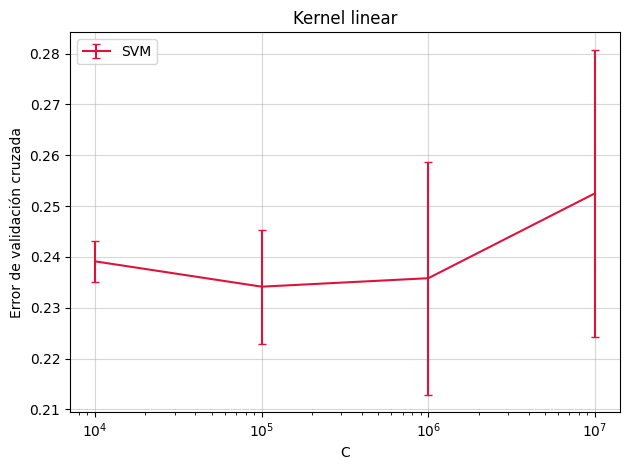

In [6]:
fig_gf, axes_gf = plt.subplots(1,1)

errorVal(cv_results_gf_lineal, fig_gf, kernel_type='linear')

fig_gf.savefig('lineal_gf.pdf')

plt.tight_layout()
plt.show()

El mejor modelo con *kernel* lineal lo tenemos para un valor de $C = 10^5$.

**Resultados *kernel* polinómico: gráfica de entrenamiento y mejor modelo**

In [7]:
with open('resultados/cv_results_gf_poly.pkl', 'rb') as f:
    cv_results_gf_poly = pickle.load(f)
    
best_poly = cv_results_gf_poly[cv_results_gf_poly['rank_test_score'] == min(list(cv_results_gf_poly['rank_test_score']))]
best_poly.loc[:, ['param_C', 'param_kernel', 'param_degree', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,param_degree,param_gamma,mean_test_score,mean_test_error,std_test_score,rank_test_score
3,10000,poly,3,1,0.779272,0.220728,0.037121,1


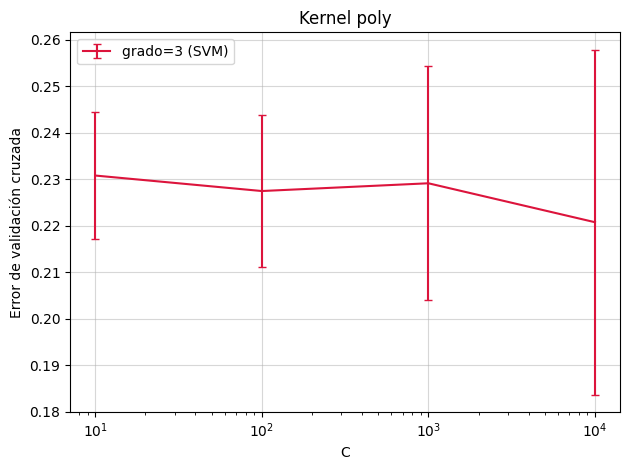

In [8]:
fig_gf_poly, axes_gf_poly = plt.subplots(1,1)

errorVal(cv_results_gf_poly, fig_gf_poly, kernel_type='poly')

fig_gf_poly.savefig('poly_gf.pdf')

plt.tight_layout()
plt.show()

El mejor modelo con *kernel* polinómico lo tenemos para grado 3, $\gamma = 1$ y un valor de $C = 10^4$ (aunque la gráfica parece que descienda, ya vimos en la exploración gruesa que el error de validación cruzada en $10^5$ era mayor).

**Resultados *kernel* radial: gráfica de entrenamiento y mejor modelo**

In [9]:
with open('resultados/cv_results_gf_rbf.pkl', 'rb') as f:
    cv_results_gf_rbf = pickle.load(f)

best_rbf = cv_results_gf_rbf[cv_results_gf_rbf['rank_test_score'] == min(list(cv_results_gf_rbf['rank_test_score']))]
best_rbf.loc[:, ['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,param_gamma,mean_test_score,mean_test_error,std_test_score,rank_test_score
2,1,rbf,1,0.804384,0.195616,0.021161,1


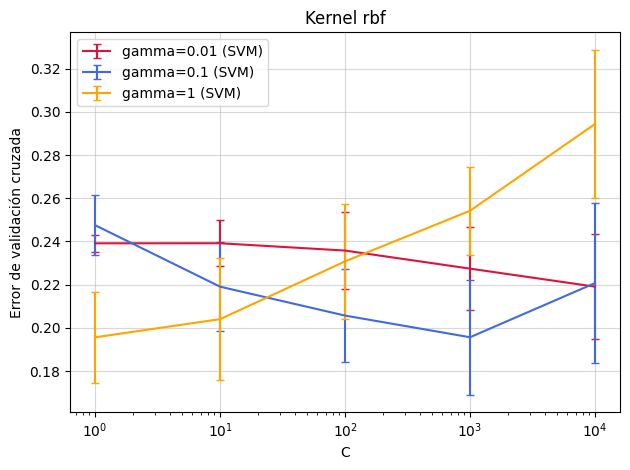

In [10]:
fig_gf_rbf, axes_gf_rbf = plt.subplots(1,1)

errorVal(cv_results_gf_rbf, fig_gf_rbf, kernel_type='rbf')

fig_gf_rbf.savefig('radial_gf.pdf')

plt.tight_layout()
plt.show()

El mejor modelo con *kernel* radial lo tenemos para un valor de $C = 1$ y $\gamma = 1$. 

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos). 

Recogemos el rango de hiperparámetros que usamos para la exploración de grano fino. Como esto no requiere mucho tiempo de cómputo, pasaremos los tres *kernel* directamente en el mismo *grid* de hiperparámetros.

In [47]:
hyperparameters_gf = [{'kernel': ['linear'], 'C': [10**i for i in range(4, 8, 1)]}, 
                      {'kernel': ['poly'], 'C': [10**i for i in range(1, 5, 1)], 'degree': [3], 'gamma': [1]}, 
                      {'kernel': ['rbf'], 'C': [10**i for i in range(0, 5, 1)], 'gamma': [10**i for i in range(-2, 1, 1)]}]

In [48]:
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

svm_test = SVC(random_state=SEED_VALUE)

modeloCV_test, cv_results_test = crossVal(dataset_all_X_scaled, np.ravel(dataset_all_Y.astype(int)), 
                                          svm_test, hyperparameters_gf, cv = ps)
modeloCV_test

Fitting 1 folds for each of 23 candidates, totalling 23 fits
[CV 1/1] END .........................C=10000, kernel=linear; total time=  37.5s
[CV 1/1] END ........................C=100000, kernel=linear; total time= 1.0min
[CV 1/1] END .......................C=1000000, kernel=linear; total time= 1.7min
[CV 1/1] END ......................C=10000000, kernel=linear; total time= 2.8min
[CV 1/1] END ...........C=10, degree=3, gamma=1, kernel=poly; total time=   7.1s
[CV 1/1] END ..........C=100, degree=3, gamma=1, kernel=poly; total time=  52.6s
[CV 1/1] END .........C=1000, degree=3, gamma=1, kernel=poly; total time= 1.2min
[CV 1/1] END ........C=10000, degree=3, gamma=1, kernel=poly; total time= 2.6min
[CV 1/1] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/1] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/1] END .......................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV 1/1] END ...................C=10, gamma=0.01

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1),
             param_grid=[{'C': [10000, 100000, 1000000, 10000000],
                          'kernel': ['linear']},
                         {'C': [10, 100, 1000, 10000], 'degree': [3],
                          'gamma': [1], 'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000, 10000],
                          'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy', verbose=3)

Separamos los resultados de los distintos *kernel*.

In [49]:
linear_test = cv_results_test[cv_results_test['param_kernel'] == 'linear']
poly_test = cv_results_test[cv_results_test['param_kernel'] == 'poly']
rbf_test = cv_results_test[cv_results_test['param_kernel'] == 'rbf']

Cogemos los resultados del modelo que mostró un menor error de validación cruzada en el conjunto de entrenamiento y vemos los resultados numéricos y gráficos en el conjunto de test, comparando con los resultados de validación.

In [56]:
best_linear_test = linear_test[linear_test['param_C'] == 100000] 

best_poly_test = poly_test[(poly_test['param_C'] == 10000) & 
                           (poly_test['param_degree'] == 3)]

best_rbf_test = rbf_test[(rbf_test['param_C'] == 1) & 
                         (rbf_test['param_gamma'] == 1)]

**Resultados kernel lineal**

In [57]:
best_linear_test.loc[:, ['param_C', 'param_kernel', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,mean_test_score,mean_test_error,std_test_score,rank_test_score
1,100000,linear,0.78,0.22,0.0,4


**Resultados kernel polinómico**

In [58]:
best_poly_test.loc[:, ['param_C', 'param_kernel', 'param_degree', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,param_degree,param_gamma,mean_test_score,mean_test_error,std_test_score,rank_test_score
7,10000,poly,3,1,0.766667,0.233333,0.0,13


**Resultados kernel radial**

In [59]:
best_rbf_test.loc[:, ['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_C,param_kernel,param_gamma,mean_test_score,mean_test_error,std_test_score,rank_test_score
10,1,rbf,1,0.773333,0.226667,0.0,7


**Error de validación vs test**

Ahora mostramos la gráfica del error de *test* frente al valor del hiperparámetro junto con la del error de entrenamiento, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


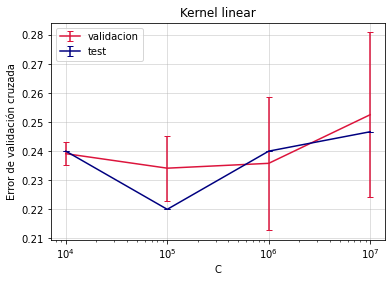

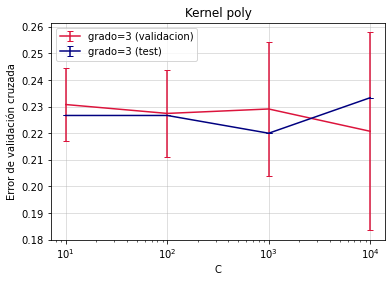

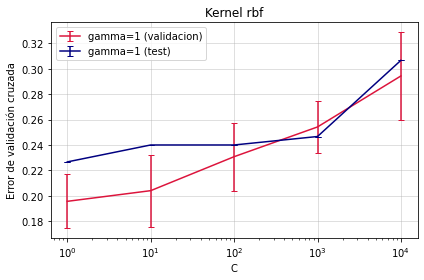

In [74]:
fig_test, axes_test = plt.subplots(1,1)
fig_test2, axes_test2 = plt.subplots(1,1)
fig_test3, axes_test3 = plt.subplots(1,1)

errorVal(cv_results_gf_lineal, fig_test, kernel_type='linear', label='validacion')
errorVal(linear_test, fig_test, kernel_type='linear', color=['navy'], label='test')

errorVal(cv_results_gf_poly, fig_test2, kernel_type='poly', label='validacion')
errorVal(poly_test, fig_test2, kernel_type='poly', color=['navy'], label='test')

errorVal(cv_results_gf_rbf[cv_results_gf_rbf['param_gamma'] == 1], fig_test3, kernel_type='rbf', label='validacion')
errorVal(rbf_test[rbf_test['param_gamma'] == 1], fig_test3, kernel_type='rbf', color=['navy'], label='test')

fig_test.savefig('linealTest.png')
fig_test2.savefig('polyTest.png')
fig_test3.savefig('radialTest.png')
plt.tight_layout()
plt.show()

Vemos que el error de *test* sigue de forma aproximada la tendencia del error de validación, pero los valores son distintos. 